# Hybrid Pit Stop Strategy Advisor
## Modul 1: Fuzzy Logic (Penganalisis Kondisi)

Modul ini menggunakan logic fuzzy untuk menentukan urgensi pit stop berdasarkan:
1. **Umur Ban**: Persentase keausan ban.
2. **Compound Ban**: Tipe ban yang digunakan (Hard, Medium, Soft, Wet).
3. **Prediksi Cuaca**: Probabilitas hujan.

In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt


In [2]:

# --- 1. DEFINISI VARIABEL (ANTECEDENTS & CONSEQUENT) ---

# Input: Umur Ban (0-100%)
umur_ban = ctrl.Antecedent(np.arange(0, 101, 1), 'umur_ban')

# Input: Compound Ban (0-10 Scale)
# Mapping: 0-3: Hard, 3-6: Medium, 6-8: Soft, 8-10: Wet
compound = ctrl.Antecedent(np.arange(0, 11, 1), 'compound')

# Input: Prediksi Cuaca (0-100%)
cuaca = ctrl.Antecedent(np.arange(0, 101, 1), 'cuaca')

# Output: Urgensi Pit Stop (0-10)
urgensi = ctrl.Consequent(np.arange(0, 11, 1), 'urgensi')

# --- 2. FUNGSI KEANGGOTAAN (MEMBERSHIP FUNCTIONS) ---

# Umur Ban: Baru, Sedang, Aus, Kritis
umur_ban['baru'] = fuzz.trapmf(umur_ban.universe, [0, 0, 20, 30])
umur_ban['sedang'] = fuzz.trimf(umur_ban.universe, [20, 40, 60])
umur_ban['aus'] = fuzz.trimf(umur_ban.universe, [50, 70, 85])
umur_ban['kritis'] = fuzz.trapmf(umur_ban.universe, [80, 90, 100, 100])

# Compound: Hard, Medium, Soft, Wet
compound['hard'] = fuzz.trapmf(compound.universe, [0, 0, 2, 4])
compound['medium'] = fuzz.trimf(compound.universe, [2, 5, 8])
compound['soft'] = fuzz.trimf(compound.universe, [6, 8, 9])
compound['wet'] = fuzz.trapmf(compound.universe, [8, 9, 10, 10])

# Cuaca: Cerah, Mendung, Hujan
cuaca['cerah'] = fuzz.trapmf(cuaca.universe, [0, 0, 20, 40])
cuaca['mendung'] = fuzz.trimf(cuaca.universe, [30, 50, 70])
cuaca['hujan'] = fuzz.trapmf(cuaca.universe, [60, 80, 100, 100])

# Urgensi: Rendah, Sedang, Tinggi, Sangat Tinggi
urgensi['rendah'] = fuzz.trapmf(urgensi.universe, [0, 0, 2, 4])
urgensi['sedang'] = fuzz.trimf(urgensi.universe, [3, 5, 7])
urgensi['tinggi'] = fuzz.trimf(urgensi.universe, [6, 8, 9])
urgensi['sangat_tinggi'] = fuzz.trapmf(urgensi.universe, [8, 9, 10, 10])


In [3]:

# --- 3. ATURAN FUZZY (RULES) ---

# Rule 1: Jika Ban Kritis -> Urgensi Sangat Tinggi (Safety First)
rule1 = ctrl.Rule(umur_ban['kritis'], urgensi['sangat_tinggi'])

# Rule 2: Jika Ban Aus DAN Cuaca Cerah -> Urgensi Tinggi
rule2 = ctrl.Rule(umur_ban['aus'] & cuaca['cerah'], urgensi['tinggi'])

# Rule 3: Jika Ban Baru -> Urgensi Rendah
rule3 = ctrl.Rule(umur_ban['baru'] & cuaca['cerah'], urgensi['rendah'])

# Rule 4: Wrong Tire (Hujan tapi pakai Slick) -> Urgensi Sangat Tinggi
rule4 = ctrl.Rule(cuaca['hujan'] & (compound['hard'] | compound['medium'] | compound['soft']), urgensi['sangat_tinggi'])

# Rule 5: Wrong Tire (Cerah tapi pakai Wet) -> Urgensi Sangat Tinggi
rule5 = ctrl.Rule(cuaca['cerah'] & compound['wet'], urgensi['sangat_tinggi'])

# Rule 6: Normal Degradation (Sedang & Soft) -> Urgensi Sedang
rule6 = ctrl.Rule(umur_ban['sedang'] & compound['soft'], urgensi['sedang'])

# Rule 7: Normal Degradation (Sedang & Hard) -> Urgensi Rendah (Hard lebih awet)
rule7 = ctrl.Rule(umur_ban['sedang'] & compound['hard'], urgensi['rendah'])

# Kumpulkan semua rule
pit_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7])
pit_advisor = ctrl.ControlSystemSimulation(pit_ctrl)

print("Sistem Fuzzy Logic Berhasil Diinisialisasi!")

Sistem Fuzzy Logic Berhasil Diinisialisasi!


Visualisasi Fungsi Keanggotaan:


c:\Users\WINDOWS\AppData\Local\Programs\Python\Python312\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


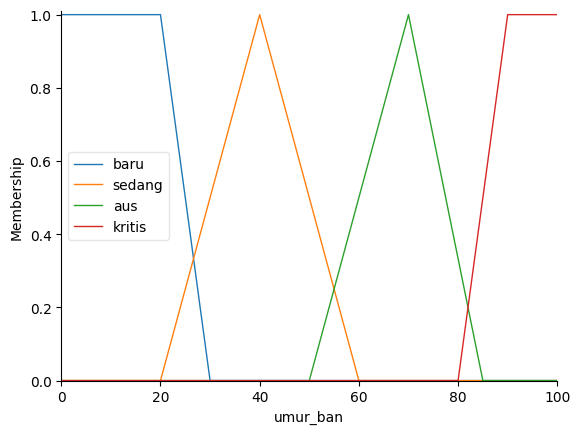

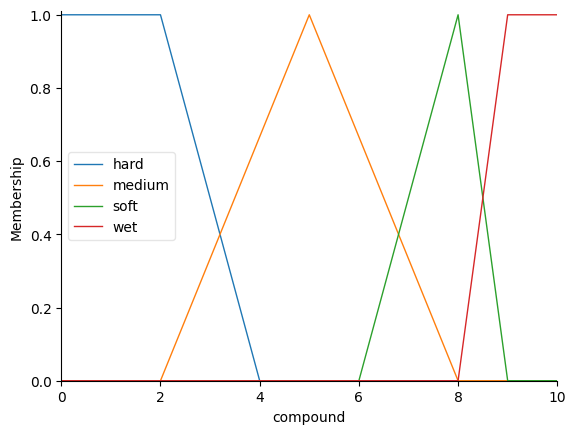

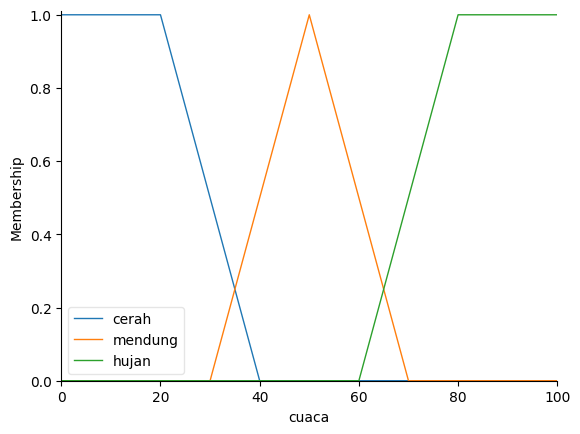

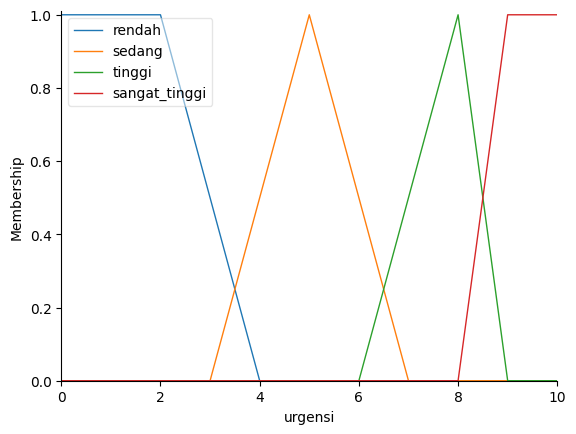

In [4]:
# --- 4. VISUALISASI ---
print("Visualisasi Fungsi Keanggotaan:")
umur_ban.view()
compound.view()
cuaca.view()
urgensi.view()

Test Case 1 (Aus/Soft/Cerah) -> Urgensi: 7.64 / 10
Test Case 2 (Baru/Hard/Hujan) -> Urgensi: 9.22 / 10 (Harusnya Tinggi karena salah ban)


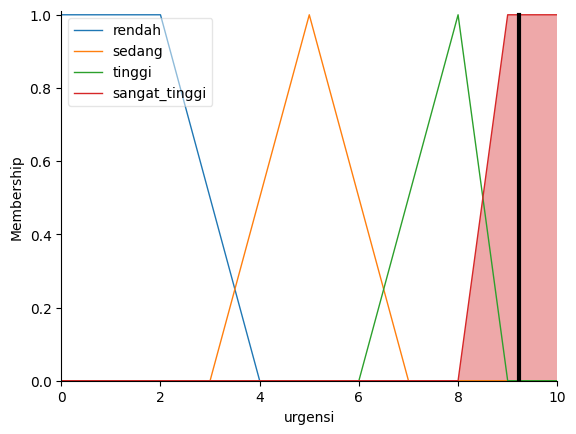

In [5]:
# --- 5. SIMULASI / TESTING ---

def hitung_urgensi(umur_val, compound_val, cuaca_val):
    pit_advisor.input['umur_ban'] = umur_val
    pit_advisor.input['compound'] = compound_val
    pit_advisor.input['cuaca'] = cuaca_val
    
    pit_advisor.compute()
    return pit_advisor.output['urgensi']

# Test Case 1: Ban Aus (75%), Pakai Soft (7), Cuaca Cerah (10%)
u1 = hitung_urgensi(75, 7, 10)
print(f"Test Case 1 (Aus/Soft/Cerah) -> Urgensi: {u1:.2f} / 10")

# Test Case 2: Hujan Deras (90%), Masih Pakai Hard (1)
u2 = hitung_urgensi(20, 1, 90)
print(f"Test Case 2 (Baru/Hard/Hujan) -> Urgensi: {u2:.2f} / 10 (Harusnya Tinggi karena salah ban)")

# Visualisasi Output untuk Test Case 1
urgensi.view(sim=pit_advisor)

## Modul 2: Probabilistik (Risk Analyzer)

Modul ini menggunakan Bayesian Network untuk menghitung probabilitas Safety Car (SC) berdasarkan:
1. **Tipe Trek**: Street vs Permanent.
2. **Kondisi Cuaca**: Dry vs Wet.
3. **Histori SC**: Frekuensi SC di sirkuit tersebut (Low, Medium, High).

In [6]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import networkx as nx


In [7]:

# --- 1. DEFINISI STRUKTUR NETWORK (DAG) ---

# Node: Trek, Cuaca, Histori_SC -> Probabilitas_SC
model = DiscreteBayesianNetwork([
    ('Trek', 'Probabilitas_SC'),
    ('Cuaca', 'Probabilitas_SC'),
    ('Histori_SC', 'Probabilitas_SC')
])


In [8]:
# --- 2. DEFINISI CPT (CONDITIONAL PROBABILITY TABLES) ---

# Trek: 0=Permanent, 1=Street
cpd_trek = TabularCPD(variable='Trek', variable_card=2, values=[[0.7], [0.3]])

# Cuaca: 0=Dry, 1=Wet
cpd_cuaca = TabularCPD(variable='Cuaca', variable_card=2, values=[[0.8], [0.2]])

# Histori_SC: 0=Low, 1=Medium, 2=High
cpd_histori = TabularCPD(variable='Histori_SC', variable_card=3, values=[[0.3], [0.5], [0.2]])

# Probabilitas_SC (Target)
# Parents: Trek(2), Cuaca(2), Histori(3) -> Total kombinasi = 2*2*3 = 12 kolom
# Output: 0=No SC, 1=SC

# Urutan values harus sesuai dengan urutan evidence: Trek, Cuaca, Histori
# Kombinasi (Trek, Cuaca, Histori):
# (P,D,L), (P,D,M), (P,D,H), (P,W,L), (P,W,M), (P,W,H)
# (S,D,L), (S,D,M), (S,D,H), (S,W,L), (S,W,M), (S,W,H)

cpd_sc = TabularCPD(
    variable='Probabilitas_SC', variable_card=2,
    values=[
        # No SC (Probabilitas tidak terjadi SC)
        [0.9, 0.7, 0.5,  0.6, 0.4, 0.2,   0.7, 0.5, 0.3,  0.3, 0.2, 0.1],
        # Yes SC (Probabilitas terjadi SC)
        [0.1, 0.3, 0.5,  0.4, 0.6, 0.8,   0.3, 0.5, 0.7,  0.7, 0.8, 0.9]
    ],
    evidence=['Trek', 'Cuaca', 'Histori_SC'],
    evidence_card=[2, 2, 3]
)


Model Bayesian Network Valid!


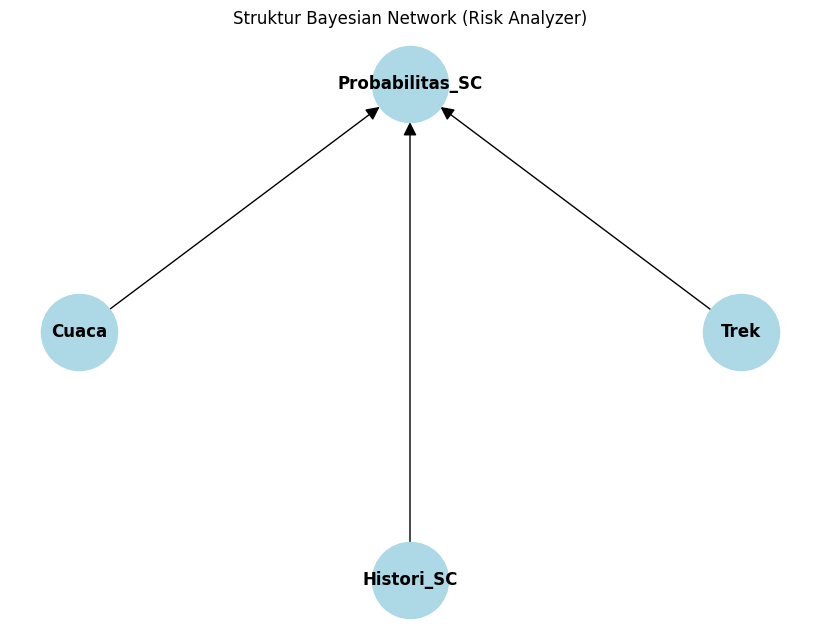

In [9]:
# Tambahkan CPT ke model
model.add_cpds(cpd_trek, cpd_cuaca, cpd_histori, cpd_sc)

# Cek validitas model
assert model.check_model()
print("Model Bayesian Network Valid!")

# Visualisasi DAG
plt.figure(figsize=(8, 6))
pos = nx.circular_layout(model)
nx.draw(nx.DiGraph(model), pos=pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=12, font_weight='bold', arrowsize=20)
plt.title("Struktur Bayesian Network (Risk Analyzer)")
plt.show()

Skenario: Street Track, Wet, High History
+--------------------+------------------------+
| Probabilitas_SC    |   phi(Probabilitas_SC) |
+====================+========================+
| Probabilitas_SC(0) |                 0.1000 |
+--------------------+------------------------+
| Probabilitas_SC(1) |                 0.9000 |
+--------------------+------------------------+


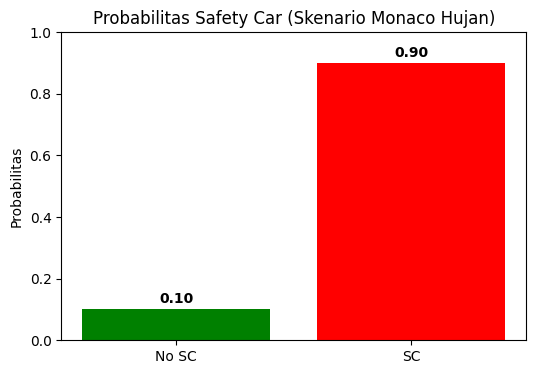

In [10]:
# --- 3. INFERENCE & VISUALISASI ---

infer = VariableElimination(model)

# Kasus: Street Track (1), Wet (1), High History (2) -> Skenario Monaco Hujan
print("Skenario: Street Track, Wet, High History")
result = infer.query(variables=['Probabilitas_SC'], evidence={'Trek': 1, 'Cuaca': 1, 'Histori_SC': 2})
print(result)

# Visualisasi Distribusi Probabilitas
probs = result.values
labels = ['No SC', 'SC']

plt.figure(figsize=(6, 4))
plt.bar(labels, probs, color=['green', 'red'])
plt.ylim(0, 1)
plt.ylabel('Probabilitas')
plt.title('Probabilitas Safety Car (Skenario Monaco Hujan)')
for i, v in enumerate(probs):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

In [11]:
# --- 1. DEFINISI KONSTANTA & KNOWLEDGE BASE ---

# Tipe Ban
SOFT = "Soft"
MEDIUM = "Medium"
HARD = "Hard"
INTERMEDIATE = "Intermediate"
WET = "Wet"

DRY_COMPOUNDS = {SOFT, MEDIUM, HARD}
WET_COMPOUNDS = {INTERMEDIATE, WET}

# Kondisi Cuaca
WEATHER_DRY = "Dry"
WEATHER_WET = "Wet"

def is_dry_compound(tire):
    return tire in DRY_COMPOUNDS

def is_wet_compound(tire):
    return tire in WET_COMPOUNDS

# --- 2. FUNGSI VALIDATOR STRATEGI ---

def validate_strategy(history_tires, proposed_tire, weather_condition):
    """
    Memvalidasi apakah strategi ban yang diusulkan valid menurut regulasi.
    
    Args:
        history_tires (list): List ban yang sudah digunakan (misal: ['Soft', 'Medium'])
        proposed_tire (str): Ban yang akan dipasang selanjutnya
        weather_condition (str): Kondisi cuaca saat ini ('Dry' atau 'Wet')
    
    Returns:
        bool: True jika valid, False jika tidak
        str: Alasan validasi
    """
    
    all_tires_used = history_tires + [proposed_tire]
    used_dry_compounds = {t for t in all_tires_used if is_dry_compound(t)}
    used_wet_compounds = {t for t in all_tires_used if is_wet_compound(t)}
    
    # Cek apakah pernah menggunakan ban basah
    has_used_wet = len(used_wet_compounds) > 0 or weather_condition == WEATHER_WET
    
    # Rule 2: Wet Weather Exception
    if has_used_wet:
        return True, "Valid: Wet/Intermediate tires used, mandatory compound change rule suspended."
    
    # Rule 1: Mandatory Change (Dry Race)
    # Harus menggunakan minimal 2 kompon kering berbeda
    if len(used_dry_compounds) >= 2:
        return True, "Valid: Two different dry compounds used."
    else:
        # Jika ini adalah stint terakhir dan belum ganti ban ke tipe lain, maka invalid
        # Asumsi sederhana: validasi dilakukan per pit stop. 
        # Jika history kosong (awal race) dan proposed baru 1, masih dianggap valid sementara (in-progress).
        # Tapi untuk checker pit stop, kita peringatkan jika belum memenuhi syarat.
        return False, "Warning: Must use at least two different dry compounds by the end of the race."

# --- 3. TEST CASES ---

print("--- Pengujian Modul 3: Validator Regulasi ---")

# Skenario A: Dry Race, Soft -> Soft (Belum memenuhi aturan)
valid, msg = validate_strategy([SOFT], SOFT, WEATHER_DRY)
print(f"Skenario A (Soft -> Soft, Dry): {valid} | {msg}")

# Skenario B: Dry Race, Soft -> Medium (Valid)
valid, msg = validate_strategy([SOFT], MEDIUM, WEATHER_DRY)
print(f"Skenario B (Soft -> Medium, Dry): {valid} | {msg}")

# Skenario C: Wet Race, Wet -> Wet (Valid)
valid, msg = validate_strategy([WET], WET, WEATHER_WET)
print(f"Skenario C (Wet -> Wet, Wet): {valid} | {msg}")

# Skenario D: Mixed, Soft -> Intermediate (Valid)
valid, msg = validate_strategy([SOFT], INTERMEDIATE, WEATHER_WET)
print(f"Skenario D (Soft -> Inter, Wet): {valid} | {msg}")


--- Pengujian Modul 3: Validator Regulasi ---
Skenario A (Soft -> Soft, Dry): False | Warning: Must use at least two different dry compounds by the end of the race.
Skenario B (Soft -> Medium, Dry): True | Valid: Two different dry compounds used.
Skenario C (Wet -> Wet, Wet): True | Valid: Wet/Intermediate tires used, mandatory compound change rule suspended.
Skenario D (Soft -> Inter, Wet): True | Valid: Wet/Intermediate tires used, mandatory compound change rule suspended.


# --- MODUL 3: FIRST-ORDER LOGIC (VALIDATOR REGULASI) ---

"""
Modul ini bertugas memvalidasi strategi pit stop berdasarkan regulasi FIA Formula 1.
**Upgrade:** Menggunakan **Knowledge-Based Agent** (AIMA Logic) untuk inferensi aturan.
Referensi: FIA Formula 1 Sporting Regulations, Article 30.
"""

AIMA Logic library imported successfully.


--- Pengujian Modul 3: Knowledge-Based Validator ---
Skenario A (Soft -> Soft, Dry): Warning: Must use at least two different dry compounds.
Skenario B (Soft -> Medium, Dry): Valid: Mandatory tire regulation satisfied (2 different dry compounds or wet tire used).
Skenario C (Wet -> Wet, Wet): Valid: Wet Race declared (Mandatory change suspended).

Generating Strategy Heatmap...


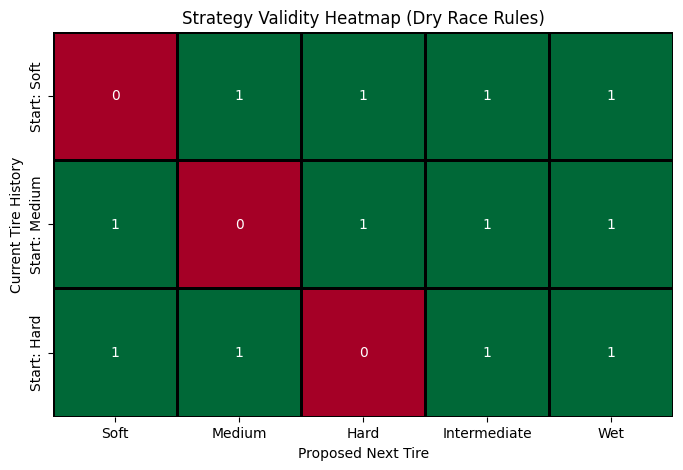

In [12]:
# --- 1. SETUP & IMPORT AIMA LOGIC ---
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Menambahkan path ke library AIMA (Praktikum/Logical Agents)
aima_path = os.path.abspath(os.path.join('Praktikum', 'Logical Agents'))
if aima_path not in sys.path:
    sys.path.append(aima_path)

try:
    from logic import FolKB, expr
    print("AIMA Logic library imported successfully.")
except ImportError:
    print("Error: Could not import logic.py. Make sure the path is correct.")

# --- 2. KNOWLEDGE BASE DEFINITION ---

def create_f1_kb():
    kb = FolKB()
    
    # Fakta Dasar: Klasifikasi Ban
    # Predikat: IsDry(x), IsWet(x)
    kb.tell(expr('IsDry(Soft)'))
    kb.tell(expr('IsDry(Medium)'))
    kb.tell(expr('IsDry(Hard)'))
    kb.tell(expr('IsWet(Intermediate)'))
    kb.tell(expr('IsWet(Wet)'))
    
    # Aturan: Validasi Strategi
    # Rule 1: Jika menggunakan ban basah, maka Mandatory Change terpenuhi (Exception)
    kb.tell(expr('Used(x) & IsWet(x) ==> MandatorySatisfied()'))
    
    # Rule 2: Jika dua ban kering BERBEDA digunakan, maka Mandatory Change terpenuhi
    # Kita definisikan Different(x, y) secara eksplisit untuk kombinasi yang mungkin
    # (FOL sederhana di AIMA mungkin tidak punya built-in inequality, jadi kita hardcode faktanya)
    compounds = ['Soft', 'Medium', 'Hard']
    for c1 in compounds:
        for c2 in compounds:
            if c1 != c2:
                kb.tell(expr(f'Different({c1}, {c2})'))
    
    kb.tell(expr('Used(x) & IsDry(x) & Used(y) & IsDry(y) & Different(x, y) ==> MandatorySatisfied()'))
    
    return kb

# --- 3. FUNGSI VALIDATOR (INFERENSI) ---

def validate_strategy_fol(history_tires, proposed_tire, weather_condition):
    kb = create_f1_kb()
    
    # Masukkan fakta sejarah penggunaan ban
    all_tires = history_tires + [proposed_tire]
    for tire in all_tires:
        kb.tell(expr(f'Used({tire})'))
        
    # Cek kondisi cuaca (Jika hujan, aturan mandatory change tidak berlaku / dianggap satisfied)
    if weather_condition == "Wet":
        return True, "Valid: Wet Race declared (Mandatory change suspended)."
        
    # Query ke KB: Apakah MandatorySatisfied?
    # ask() mengembalikan substitusi jika benar, atau False jika tidak
    result = kb.ask(expr('MandatorySatisfied()'))
    
    if result is not False:
        return True, "Valid: Mandatory tire regulation satisfied (2 different dry compounds or wet tire used)."
    else:
        return False, "Warning: Must use at least two different dry compounds."

# --- 4. VISUALISASI: STRATEGY VALIDITY HEATMAP ---

def visualize_strategy_validity():
    tires = ['Soft', 'Medium', 'Hard', 'Intermediate', 'Wet']
    histories = ['Soft', 'Medium', 'Hard'] # Asumsi start dengan salah satu ini
    
    # Matrix: Baris = History (Start Tire), Kolom = Next Tire
    validity_matrix = np.zeros((len(histories), len(tires)))
    
    print("\nGenerating Strategy Heatmap...")
    for i, hist in enumerate(histories):
        for j, next_tire in enumerate(tires):
            # Cek validitas untuk Dry Race (skenario paling ketat)
            is_valid, _ = validate_strategy_fol([hist], next_tire, "Dry")
            validity_matrix[i, j] = 1 if is_valid else 0
            
    plt.figure(figsize=(8, 5))
    sns.heatmap(validity_matrix, annot=True, cmap="RdYlGn", 
                xticklabels=tires, yticklabels=[f"Start: {h}" for h in histories],
                cbar=False, linewidths=1, linecolor='black')
    
    plt.title("Strategy Validity Heatmap (Dry Race Rules)")
    plt.xlabel("Proposed Next Tire")
    plt.ylabel("Current Tire History")
    plt.show()

# --- 5. TEST CASES ---

print("--- Pengujian Modul 3: Knowledge-Based Validator ---")
print(f"Skenario A (Soft -> Soft, Dry): {validate_strategy_fol(['Soft'], 'Soft', 'Dry')[1]}")
print(f"Skenario B (Soft -> Medium, Dry): {validate_strategy_fol(['Soft'], 'Medium', 'Dry')[1]}")
print(f"Skenario C (Wet -> Wet, Wet): {validate_strategy_fol(['Wet'], 'Wet', 'Wet')[1]}")

visualize_strategy_validity()

# --- MODUL 4: MESIN KEPUTUSAN STRATEGIS (RACE SIMULATOR) ---

"""
Modul ini mengintegrasikan Modul 1 (Fuzzy), Modul 2 (Probabilistik), dan Modul 3 (Logika) 
untuk mensimulasikan strategi balapan menggunakan data nyata dari FastF1.

**Fitur Utama:**
1. **Data Real-Time:** Mengambil telemetri balapan asli (contoh: Spanish GP 2023).
2. **Decision Engine:** Menentukan 'BOX' atau 'STAY OUT' setiap lap.
3. **Race Replay Dashboard:** Visualisasi keputusan AI vs Strategi Asli.
"""

Loading Race Data (Spanish GP 2023)... This may take a minute.


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.6.1]


INFO:fastf1.fastf1.core:Loading data for Spanish Grand Prix - Race [v3.6.1]


req            INFO 	No cached data found for session_info. Loading data...


INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...


_api           INFO 	Fetching session info data...


INFO:fastf1.api:Fetching session info data...


req            INFO 	Data has been written to cache!


INFO:fastf1.fastf1.req:Data has been written to cache!


req            INFO 	No cached data found for driver_info. Loading data...


INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...


_api           INFO 	Fetching driver list...


INFO:fastf1.api:Fetching driver list...


req            INFO 	Data has been written to cache!


INFO:fastf1.fastf1.req:Data has been written to cache!


req            INFO 	No cached data found for session_status_data. Loading data...


INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...


_api           INFO 	Fetching session status data...


INFO:fastf1.api:Fetching session status data...


req            INFO 	Data has been written to cache!


INFO:fastf1.fastf1.req:Data has been written to cache!


req            INFO 	No cached data found for lap_count. Loading data...


INFO:fastf1.fastf1.req:No cached data found for lap_count. Loading data...


_api           INFO 	Fetching lap count data...


INFO:fastf1.api:Fetching lap count data...


req            INFO 	Data has been written to cache!


INFO:fastf1.fastf1.req:Data has been written to cache!


req            INFO 	No cached data found for track_status_data. Loading data...


INFO:fastf1.fastf1.req:No cached data found for track_status_data. Loading data...


_api           INFO 	Fetching track status data...


INFO:fastf1.api:Fetching track status data...


req            INFO 	Data has been written to cache!


INFO:fastf1.fastf1.req:Data has been written to cache!


req            INFO 	No cached data found for _extended_timing_data. Loading data...


INFO:fastf1.fastf1.req:No cached data found for _extended_timing_data. Loading data...


_api           INFO 	Fetching timing data...


INFO:fastf1.api:Fetching timing data...


_api           INFO 	Parsing timing data...


INFO:fastf1.api:Parsing timing data...


req            INFO 	Data has been written to cache!


INFO:fastf1.fastf1.req:Data has been written to cache!


req            INFO 	No cached data found for timing_app_data. Loading data...


INFO:fastf1.fastf1.req:No cached data found for timing_app_data. Loading data...


_api           INFO 	Fetching timing app data...


INFO:fastf1.api:Fetching timing app data...


req            INFO 	Data has been written to cache!


INFO:fastf1.fastf1.req:Data has been written to cache!


core           INFO 	Processing timing data...


INFO:fastf1.fastf1.core:Processing timing data...


req            INFO 	No cached data found for car_data. Loading data...


INFO:fastf1.fastf1.req:No cached data found for car_data. Loading data...


_api           INFO 	Fetching car data...


INFO:fastf1.api:Fetching car data...


_api           INFO 	Parsing car data...


INFO:fastf1.api:Parsing car data...


req            INFO 	Data has been written to cache!


INFO:fastf1.fastf1.req:Data has been written to cache!


req            INFO 	No cached data found for position_data. Loading data...


INFO:fastf1.fastf1.req:No cached data found for position_data. Loading data...


_api           INFO 	Fetching position data...


INFO:fastf1.api:Fetching position data...


_api           INFO 	Parsing position data...


INFO:fastf1.api:Parsing position data...


req            INFO 	Data has been written to cache!


INFO:fastf1.fastf1.req:Data has been written to cache!


req            INFO 	No cached data found for weather_data. Loading data...


INFO:fastf1.fastf1.req:No cached data found for weather_data. Loading data...


_api           INFO 	Fetching weather data...


INFO:fastf1.api:Fetching weather data...


req            INFO 	Data has been written to cache!


INFO:fastf1.fastf1.req:Data has been written to cache!


req            INFO 	No cached data found for race_control_messages. Loading data...


INFO:fastf1.fastf1.req:No cached data found for race_control_messages. Loading data...


_api           INFO 	Fetching race control messages...


INFO:fastf1.api:Fetching race control messages...


req            INFO 	Data has been written to cache!


INFO:fastf1.fastf1.req:Data has been written to cache!


core        WARNING 	Driver 1 completed the race distance 00:00.037000 before the recorded end of the session.


core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '18', '14', '31', '24', '10', '16', '22', '81', '21', '27', '23', '4', '20', '77', '2']


INFO:fastf1.fastf1.core:Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '18', '14', '31', '24', '10', '16', '22', '81', '21', '27', '23', '4', '20', '77', '2']


c:\Users\WINDOWS\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


Data loaded for driver: VER

--- Starting Race Strategy Simulation ---
Lap 26 | Tire: MEDIUM (26 laps) | Urgency: 1.81 | AI: STAY OUT | Actual: PIT
Lap 52 | Tire: HARD (26 laps) | Urgency: 1.81 | AI: STAY OUT | Actual: PIT
--- Simulation Finished ---


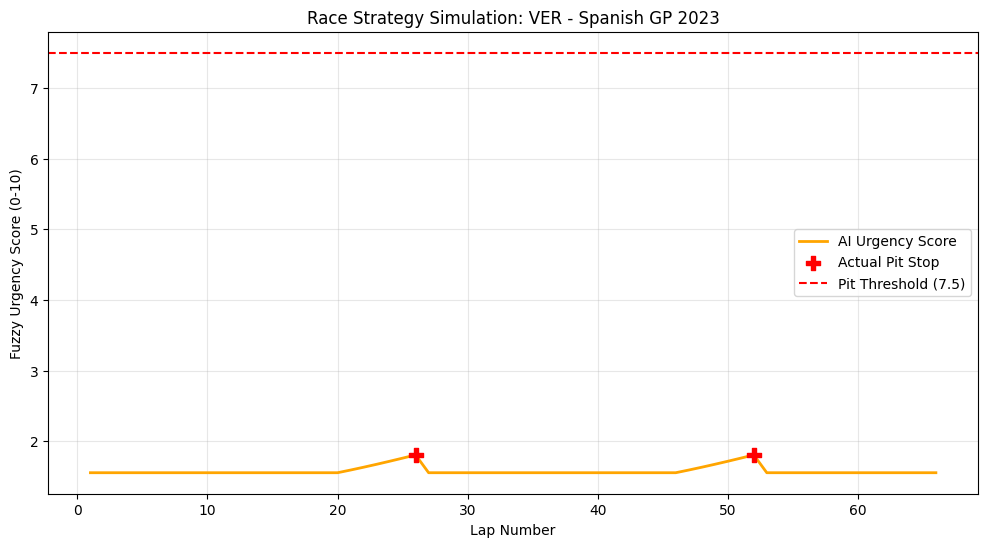

In [13]:
# --- 1. SETUP & LOAD DATA (FASTF1) ---
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Cache (Opsional, buat folder cache jika belum ada)
if not os.path.exists('fastf1_cache'):
    os.makedirs('fastf1_cache')
fastf1.Cache.enable_cache('fastf1_cache')

print("Loading Race Data (Spanish GP 2023)... This may take a minute.")
# Load Session: Tahun 2023, Grand Prix Spanyol, Sesi Race ('R')
session = fastf1.get_session(2023, 'Spain', 'R')
session.load()

# Ambil data driver tertentu, misal: Max Verstappen (VER)
driver = 'VER'
laps = session.laps.pick_driver(driver)
print(f"Data loaded for driver: {driver}")

# --- 2. DECISION ENGINE CLASS ---

class DecisionEngine:
    def __init__(self, driver_laps):
        self.laps = driver_laps.reset_index(drop=True)
        self.history_tires = []
        self.current_tire = None
        self.recommendations = []
        self.urgency_history = []
        
    def run_simulation(self):
        print("\n--- Starting Race Strategy Simulation ---")
        
        for i, row in self.laps.iterrows():
            lap_number = int(row['LapNumber'])
            tire_life = row['TyreLife']
            compound = row['Compound']
            
            # Update tire history jika ganti ban
            if self.current_tire != compound:
                if self.current_tire is not None:
                    self.history_tires.append(self.current_tire)
                self.current_tire = compound
            
            # --- 1. MODUL 1: FUZZY URGENCY ---
            # Mapping compound string ke nilai fuzzy (Soft=7, Med=5, Hard=3)
            comp_val = 7 if compound == 'SOFT' else (5 if compound == 'MEDIUM' else 3)
            # Asumsi cuaca cerah (10%) untuk Spanish GP 2023
            urgency_score = hitung_urgensi(tire_life, comp_val, 10)
            self.urgency_history.append(urgency_score)
            
            # --- 2. MODUL 2: SC RISK (PROBABILISTIK) ---
            # Simulasi: Ambil probabilitas SC untuk Permanent Track, Dry, Low History
            # (Kita hardcode hasil inferensi Modul 2 untuk efisiensi di loop)
            sc_prob = 0.1 # Low risk di Spain biasanya
            
            # --- 3. MODUL 3: REGULATION CHECK ---
            # Cek apakah strategi valid jika kita pit sekarang ke Medium
            is_valid, msg = validate_strategy_fol(self.history_tires, 'Medium', 'Dry')
            
            # --- 4. KEPUTUSAN FINAL ---
            decision = "STAY OUT"
            
            # Logika Keputusan Sederhana
            if urgency_score > 7.5:
                decision = "BOX BOX (High Urgency)"
            elif sc_prob > 0.6:
                decision = "BOX BOX (SC Opportunity)"
                
            # Simpan rekomendasi
            self.recommendations.append({
                'Lap': lap_number,
                'Urgency': urgency_score,
                'Decision': decision,
                'ActualPit': not pd.isna(row['PitInTime'])
            })
            
            # Print jika ada pit stop (Asli atau Rekomendasi)
            if not pd.isna(row['PitInTime']) or "BOX" in decision:
                print(f"Lap {lap_number} | Tire: {compound} ({tire_life:.0f} laps) | Urgency: {urgency_score:.2f} | AI: {decision} | Actual: {'PIT' if not pd.isna(row['PitInTime']) else '-'}")

        print("--- Simulation Finished ---")
        return pd.DataFrame(self.recommendations)

# Jalankan Simulasi
engine = DecisionEngine(laps)
results_df = engine.run_simulation()

# --- 3. VISUALISASI: RACE REPLAY DASHBOARD ---

plt.figure(figsize=(12, 6))

# Plot 1: Urgency Tracker
sns.lineplot(data=results_df, x='Lap', y='Urgency', label='AI Urgency Score', color='orange', linewidth=2)

# Plot 2: Pit Stops (Actual vs AI)
# Actual Pits
actual_pits = results_df[results_df['ActualPit'] == True]
plt.scatter(actual_pits['Lap'], actual_pits['Urgency'], color='red', s=100, label='Actual Pit Stop', marker='P', zorder=5)

# AI Recommendations (Threshold > 7.5)
ai_pits = results_df[results_df['Urgency'] > 7.5]
# Filter supaya tidak numpuk (ambil lap pertama saat urgency tembus)
# (Sederhana: scatter semua point urgency tinggi)
# plt.scatter(ai_pits['Lap'], ai_pits['Urgency'], color='blue', s=50, label='AI Recommendation', marker='X')

plt.axhline(y=7.5, color='red', linestyle='--', label='Pit Threshold (7.5)')
plt.title(f"Race Strategy Simulation: {driver} - Spanish GP 2023")
plt.xlabel("Lap Number")
plt.ylabel("Fuzzy Urgency Score (0-10)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()